In [1]:
# Scientific computing and data manipulation
import math
import time
import numpy as np
import pandas as pd
from scipy.integrate import odeint, solve_ivp

# Visualization
import matplotlib.pyplot as plt

# Machine learning and deep learning
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, LeaveOneOut

# Hyperparameter optimization
import optuna

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Tells whether the model is running on CPU or GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('using GPU:', torch.cuda.get_device_name()) if torch.cuda.is_available() else 'using cpu'

'using cpu'

In [3]:
#import random

# To fix the random seed
#seed = 42
#torch.manual_seed(seed)
#np.random.seed(seed)
#random.seed(seed)

# Ensure deterministic behavior in PyTorch
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

# DEFINE PARAMETERS

In [4]:
# define constant parameters

R = (6.4*10e-3)/2 # Tubular radius, units: m
qp_480 = 1.3 * 10e-4 * 60 # Photon flux, units: moles photons · m-2 · min-1
Vr = 4.78 * 10e-6# Reactor volume, units: m3
CB = 0.4 # Concentartion of reactant B, units: M

# Calculate photon flux at different power ratings

# 240 W
qp_240 = qp_480*240/480

#120 W
qp_120 = qp_480*120/480

In [5]:
# Experimentally measured parameters

phi_n1 = 0.07508614 # Quantum yield, units: mole/Einstien
k11 = 0.01953897 # rate constant for formation of species C
k21 = 0.11706072 # rate constant for formation of species E

# Regressed parameters

mpc1 = 94.6*0.02*(1/1000) # photon absorption by photocatalyst
ka1 =  324.7*(1/1000) # Napierian molar absorption coefficient of specis A, units: m2/mol
kc1 = 345.5*(1/1000) # Napierian molar absorption coefficient of specis C, units: m2/mol 

# LOAD DATA

In [6]:
# Extract Data from the Excel Data Sheet

Y1_list = []
Y2_list = []
Y3_list = []
Input_list = []
for i in range(1,10):
    name = "Sheet" + str(i)
    print(name)
    raw_input = pd.read_excel("Updated_photochemical_Experiment.xlsx",name)
    X=raw_input.values.astype(np.float64)
    X1 = X[:,2]
    Y1 = X[:,10]
    Y2 = X[:,11]
    Y3 = X[:,9]
    
    Y1_list.append(Y1)
    Y2_list.append(Y2)
    Y3_list.append(Y3)
    
    Input_list.append([X[0,0],X[0,1],Y1[0],Y2[0],Y3[0]])  #Y1,Y2,Y3 ==1,0,0


Sheet1
Sheet2
Sheet3
Sheet4
Sheet5
Sheet6
Sheet7
Sheet8
Sheet9


In [7]:
X_input = np.array(Input_list).reshape(-1,1,5)
RNN_input = X_input.repeat(36, axis=1)  # to keep consensus with the shape for RNN_output
print("RNN_input shape is {}".format(RNN_input.shape))

RNN_input shape is (9, 36, 5)


In [8]:
Y1_output = np.array(Y1_list)
Y1_output = Y1_output.reshape(-1, 36, 1)
Y2_output = np.array(Y2_list)
Y2_output = Y2_output.reshape(-1, 36, 1)
Y3_output = np.array(Y3_list)
Y3_output = Y3_output.reshape(-1, 36, 1)
RNN_output = np.concatenate((Y1_output, Y2_output, Y3_output), axis=2)
print("RNN_output shape is {}".format(RNN_output.shape))  # output shape: number of samples x timestep x variables

RNN_output shape is (9, 36, 3)


In [9]:
# Normalization

scaler_X = preprocessing.StandardScaler().fit(RNN_input.reshape(-1, 5))
scaler_y = preprocessing.StandardScaler().fit(RNN_output.reshape(-1, 3))

print(scaler_X.mean_)
print(scaler_X.var_)
print(scaler_y.mean_)
print(scaler_y.var_)

RNN_input = scaler_X.transform(RNN_input.reshape(-1, 5)).reshape(-1,36,5)
RNN_output = scaler_y.transform(RNN_output.reshape(-1, 3)).reshape(-1,36,3)

mean_y = torch.from_numpy(scaler_y.mean_).float()
std_y = torch.from_numpy(np.sqrt(scaler_y.var_)).float()

[  0.3 280.    1.    0.    0. ]
[6.66666667e-03 2.24000000e+04 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
[0.29611469 0.69253774 0.01134757]
[2.33151041e-02 2.22718238e-02 1.73960109e-05]


In [10]:
torch.save(mean_y,'mean_y.pt')
torch.save(std_y,'std_y.pt')
np.save('mean_X.npy',scaler_X.mean_)
np.save('std_X.npy',np.sqrt(scaler_X.var_))

In [11]:
# split into train and test sets
x_train = RNN_input[:7,:,:]
x_test  = RNN_input[7:,:,:]

y_train = RNN_output[:7,:,:]
y_test =  RNN_output[7:,:,:]

In [12]:
############################# Split Train, Test, and Validation dataset ##################################

#X_train, x_test, Y_train, y_test = train_test_split(RNN_input, RNN_output, test_size=0.2, random_state=42)

#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) # 0.25 x 0.8 = 0.2

print(f"X_train shape is {x_train.shape} X_test shape is {x_test.shape}")
print(f"y_train shape is {y_train.shape}, y_test shape is {y_test.shape}")

X_train shape is (7, 36, 5) X_test shape is (2, 36, 5)
y_train shape is (7, 36, 3), y_test shape is (2, 36, 3)


In [13]:
mean_X = np.load('mean_X.npy')
std_X = np.load('std_X.npy')
mean_y = torch.load('mean_y.pt')
std_y=torch.load('std_y.pt')

# GENERATING COLLOCATION POINTS

In [14]:
# generating collocation points 
# u1 = Reactant feed concentration, u2 = Power rating

u1_physics_list = np.linspace(0.1, 1, 20)
u2_physics_list = np.linspace(100, 1000, 20) 

In [15]:
u1_physics_input = list()
u2_physics_input = list()
Y_1_list = []
Y_2_list = []
Y_3_list = []

for num_id, u1 in enumerate(u1_physics_list):
    print(f"{num_id + 1} out of {u1_physics_list.shape[0]}")    #just to count and keep track
    CBi = u1 
    
    for u2 in u2_physics_list:
        F = u2 
        
        u1_physics_input.append(u1)
        u2_physics_input.append(u2)
        
        Y_1 = 1
        Y_2 = 0
        Y_3 = 0
    
        Y_1_list.append(Y_1)
        Y_2_list.append(Y_2)
        Y_3_list.append(Y_3)

1 out of 20
2 out of 20
3 out of 20
4 out of 20
5 out of 20
6 out of 20
7 out of 20
8 out of 20
9 out of 20
10 out of 20
11 out of 20
12 out of 20
13 out of 20
14 out of 20
15 out of 20
16 out of 20
17 out of 20
18 out of 20
19 out of 20
20 out of 20


In [16]:
# collate input 

u1_physics_input = np.array(u1_physics_input)
u1_physics_input = u1_physics_input.reshape(-1,1,1)

u2_physics_input = np.array(u2_physics_input)
u2_physics_input = u2_physics_input.reshape(-1,1,1)

Y_1_list = np.array(Y_1_list)
Y_1_list = Y_1_list.reshape(-1,1,1)

Y_2_list = np.array(Y_2_list)
Y_2_list = Y_2_list.reshape(-1,1,1)

Y_3_list = np.array(Y_3_list)
Y_3_list = Y_3_list.reshape(-1,1,1)

RNN_physics_input_tempc = np.concatenate((u1_physics_input, u2_physics_input, Y_1_list, Y_2_list, Y_3_list), axis=2)

"""
    the input to RNN is in the shape [number of samples x timestep x variables], and the input variables are same for every
    time step
"""

RNN_physics_input_tempc = RNN_physics_input_tempc.repeat(36, axis=1)
print("RNN_physics_input_temp shape is {}".format(RNN_physics_input_tempc.shape))

RNN_physics_input_temp shape is (400, 36, 5)


In [17]:
RNN_physics_input_tempc = scaler_X.transform(RNN_physics_input_tempc.reshape(-1, 5)).reshape(-1,36,5)

In [18]:
#X_collocation_train
x_collocation_train = RNN_physics_input_tempc[:,:,:]

In [19]:
print(f'X_collocation_train shape is: {x_collocation_train.shape}')

X_collocation_train shape is: (400, 36, 5)


# TRANSFORMING DATA FOR TRAINING

In [20]:
x_collocation_train = torch.from_numpy(x_collocation_train).float()

In [21]:
x_train = torch.from_numpy(x_train).float()
x_test = torch.from_numpy(x_test).float()

In [22]:
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

In [23]:
dataset_physics_test = TensorDataset(x_test, y_test)
dataloader_physics_test = DataLoader(dataset_physics_test, batch_size=1, shuffle=False)

# DEFINING RNN

In [24]:
class RNN(nn.Module):
    "Defines a RNN network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super(RNN, self).__init__()
        self.layers = N_LAYERS
        
        if isinstance(N_HIDDEN, list):
            self.rnn = nn.LSTM(N_INPUT, 
                                N_HIDDEN[0], 
                                batch_first=True)
            
            self.rnn1 = nn.ModuleList(
                [nn.LSTM(N_HIDDEN[i], 
                        N_HIDDEN[i+1],
                       batch_first=True) for i in range(N_LAYERS - 1)]
            )
            
            self.output_layer = nn.Linear(N_HIDDEN[-1], N_OUTPUT)
            
            self.list_flag = True
            
        else:
            self.rnn = nn.LSTM(N_INPUT, 
                                N_HIDDEN,
                                N_LAYERS,
                                batch_first=True,
                                dropout=0.1)
            
            self.output_layer = nn.Linear(N_HIDDEN, N_OUTPUT)
            
            self.list_flag = False                                             
        
    def forward(self, x):
        x, _ = self.rnn(x)
        
        if self.list_flag:
            for i in range(self.layers - 1):
                x, _ = self.rnn1[i](x)
                
        x = self.output_layer(x)
        return x

In [25]:
# Adaptive Time Step

time = X1
print(time)
# Compute t_step as before
t_step = np.diff(time)
print(t_step)
t_step = torch.from_numpy(t_step)

[ 0.          1.          2.          3.          4.          5.
  5.03586213  5.14649097  5.30111004  5.4649041   5.63867566  5.82331844
  6.01982984  6.22932528  6.4530548   6.69242217  6.94900701  7.22459021
  7.5211832   7.84106147  8.18680287  8.56133087  8.96796312  9.41046508
  9.89310801 10.42072996 10.99879691 11.63345974 13.1008564  13.94961458
 14.88695124 15.92250695 17.06627394 18.32828423 19.71819689 21.24480099]
[1.         1.         1.         1.         1.         0.03586213
 0.11062884 0.15461907 0.16379406 0.17377156 0.18464278 0.1965114
 0.20949544 0.22372951 0.23936737 0.25658484 0.2755832  0.29659298
 0.31987827 0.3457414  0.374528   0.40663225 0.44250195 0.48264293
 0.52762195 0.57806695 0.63466283 1.46739666 0.84875818 0.93733666
 1.03555572 1.14376698 1.26201029 1.38991266 1.5266041 ]


# PINN GUASSIAN

In [26]:
def train_model_sag(model, patience, n_epochs, X_collocation_train):

    train_losses_1 = []
    train_losses_i = []
    train_losses_CA = []
    train_losses_CC = []
    train_losses_CE = []
    train_losses_phy = []
    
    train_losses, valid_losses = [], []
    avg_train_losses, avg_valid_losses = [], []
    y_scaled_error= []
    
    sd = nn.Parameter(torch.tensor(1.0), requires_grad=True)  # # variance
    sCA = nn.Parameter(torch.tensor(-2.0), requires_grad=True)  # CA loss
    sCC = nn.Parameter(torch.tensor(-2.0), requires_grad=True)  # CC loss
    sCE = nn.Parameter(torch.tensor(-2.0), requires_grad=True)  # CE loss
    
    def criterion(ldata, lCA, lCC, lCE):
        # Define the adaptively weighted loss function (negative log-likelihood)
        loss_data = torch.exp(-sd) * ldata  + sd
        loss_CA = torch.exp(-sCA) * lCA + sCA
        loss_CC =  torch.exp(-sCC) * lCC + sCC
        loss_CE = torch.exp(-sCE) * lCE + sCE
        return loss_data + loss_CA + loss_CC + loss_CE
        
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Adam optimizer
    optimizer_criterion = torch.optim.Adam([sd, sCA, sCC, sCE], lr=1e-2)  # Adam optimizer for criterion

    for epoch in range(1, n_epochs + 1):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch[0].to(device), y_batch[0].to(device)
            optimizer.zero_grad()

            NN_outputd = model(x_batch)
            loss1 = torch.mean((NN_outputd - y_batch) ** 2)

            # Physics-based loss using collocation points
            X_col = X_collocation_train.to(device)
            NN_output = model(X_col)
            CA_in = X_col[:, :, 2] * std_X[2] + mean_X[2]
            CC_in = X_col[:, :, 3] * std_X[3] + mean_X[3]
            CE_in = X_col[:, :, 4] * std_X[4] + mean_X[4]
            CB = 0.4 * 1000  # mol/m3
            CAo = X_col[:, :, 0] * std_X[0] + mean_X[0]
            CAo = CAo * 1000
            qp = 1.3 * 10e-4 * 60 * (X_col[:, :, 1] * std_X[1] + mean_X[1]) / 480
            qp = qp.to(device)

            NN_output = NN_output * std_y.to(device) + mean_y.to(device)

            dCA = torch.cat([
                (NN_output[:, 1:2, 0] - CA_in[:, 0:1]) / (2 * t_step[0]),
                (NN_output[:, 2:, 0] - NN_output[:, :-2, 0]) / (2 * t_step[0:-1]),
                (NN_output[:, -1:, 0] - NN_output[:, -2:-1, 0]) / (t_step[-1])
            ], dim=1)

            dCC = torch.cat([
                (NN_output[:, 1:2, 1] - CC_in[:, 0:1]) / (2 * t_step[0]),
                (NN_output[:, 2:, 1] - NN_output[:, :-2, 1]) / (2 * t_step[0:-1]),
                (NN_output[:, -1:, 1] - NN_output[:, -2:-1, 1]) / (t_step[-1])
            ], dim=1)

            dCE = torch.cat([
                (NN_output[:, 1:2, 2] - CE_in[:, 0:1]) / (2 * t_step[0]),
                (NN_output[:, 2:, 2] - NN_output[:, :-2, 2]) / (2 * t_step[0:-1]),
                (NN_output[:, -1:, 2] - NN_output[:, -2:-1, 2]) / (t_step[-1])
            ], dim=1)

            lossCA = dCA - ((phi_n1/CAo)*(qp/Vr)*(ka1*NN_output[:, :, 0]*CAo/(mpc1+ka1*NN_output[:, :, 0]*CAo+kc1*NN_output[:, :, 1]*CAo))
                            *(1-torch.exp(-(mpc1+ka1*NN_output[:, :, 0]*CAo+kc1*NN_output[ :,:, 1]*CAo)*2*R)))
            lossCA = torch.mean(lossCA**2)
            
            lossCC = dCC - ((k11*CB)/(k11*CB+k21)**1)*((phi_n1/CAo)*(qp/Vr)*(ka1*NN_output[:, :, 0]*CAo/(mpc1+ka1*NN_output[:,:, 0]*CAo+kc1*NN_output[ :,:, 1]*CAo))
                                                       *(1-torch.exp(-(mpc1+ka1*NN_output[:, :, 0]*CAo+kc1*NN_output[:, :, 1]*CAo)*2*R)))**1
            lossCC = torch.mean(lossCC**2)
            
            lossCE = dCE - (k21/(k11*CB+k21)**1)*((phi_n1/CAo)*(qp/Vr)*(ka1*NN_output[:, :, 0]*CAo/(mpc1+ka1*NN_output[ :,:, 0]*CAo+kc1*NN_output[:,:, 1]*CAo))
                                                  *(1-torch.exp(-(mpc1+ka1*NN_output[:, :, 0]*CAo+kc1*NN_output[:, :, 1]*CAo)*2*R)))**1 
            lossCE = torch.mean(lossCE**2)
            
            # backpropagate joint loss
            loss =  torch.exp(-sd.detach()) *loss1 + torch.exp(-sCA.detach()) * lossCA + torch.exp(-sCC.detach()) * lossCC + torch.exp(-sCE.detach()) * lossCE# add all loss terms together
            
            loss.backward()
            optimizer.step()
            
            optimizer_criterion.zero_grad()
            loss_likelihood = criterion(loss1.detach(), lossCA.detach(), lossCC.detach(), lossCE.detach())

            loss_likelihood.backward()
            optimizer_criterion.step()
            
            train_losses.append(loss.item())
            train_losses_1.append(loss1.item())
            train_losses_CA.append(lossCA.item())
            train_losses_CC.append(lossCC.item())
            train_losses_CE.append(lossCE.item())
            
            # record training loss
            train_losses.append(loss.item())

        # Validation
        model.eval()
        for x_valbatch, y_valbatch in val_loader:
            x_valbatch, y_valbatch = x_valbatch[0].to(device), y_valbatch[0].to(device)
            NN_outputv = model(x_valbatch)
            loss = torch.mean((NN_outputv - y_valbatch) ** 2)

            valid_losses.append(loss.item())
        
        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch}/{n_epochs}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []   
        
        train_losses = []
        valid_losses = []
        train_losses_1 = []
        train_losses_i = []
        train_losses_CA = []
        train_losses_CC = []
        train_losses_CE = []

    model.eval()

    final_predictions = []
    final_targets = []

    with torch.no_grad():
        for x_valbatch, y_valbatch in dataloader_physics_test:
            x_valbatch, y_valbatch = x_valbatch[0].to(device), y_valbatch[0].to(device)
            output = model(x_valbatch)

            preds = scaler_y.inverse_transform(output.cpu().numpy().reshape(-1, 3)).reshape(-1, 36, 3)
            targets = scaler_y.inverse_transform(y_valbatch.cpu().numpy().reshape(-1, 3)).reshape(-1, 36, 3)

            # Compute scaled loss
            c1 = np.sum(np.abs(preds[-1, :, 0] - targets[-1, :, 0]))
            c2 = np.sum(np.abs(preds[-1, :, 1] - targets[-1, :, 1]))
            c3 = np.sum(np.abs(preds[-1, :, 2] - targets[-1, :, 2]))
            scaled_loss = (3.377069851 * c1 + 1.443964636 * c2 + 88.12458286 * c3) / 100
            
            y_scaled_error.append(scaled_loss)

            final_predictions.append(preds)
            final_targets.append(targets)

    final_predictions = np.concatenate(final_predictions, axis=0)
    final_targets = np.concatenate(final_targets, axis=0)

    return model, avg_train_losses, avg_valid_losses, np.mean(avg_valid_losses), y_scaled_error, final_predictions, final_targets


In [27]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

# create loocv procedure
cv = LeaveOneOut()

batch_size = 32
k = 7

In [28]:
y_glob = []  # Will be a list of lists: shape (n_folds, n_repeats_per_fold)
sc_y_glob = []

all_val_preds = []  # list of length n_folds, each item is (5, n_samples, 36, 3)
val_targets = None

for fold, (train_idx_A, val_idx_A) in enumerate(cv.split(x_train)):
    print(f"  Fold {fold + 1}/{k}")

    # Create TensorDatasets and DataLoaders
    train_datasetA = TensorDataset(x_train[train_idx_A], y_train[train_idx_A])
    val_datasetA = TensorDataset(x_train[val_idx_A], y_train[val_idx_A])
    train_loader = DataLoader(train_datasetA, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_datasetA, batch_size=batch_size, shuffle=False)
    
    # Select collocation data for this fold
    X_collocation_train_fold = x_collocation_train

    fold_errors = []
    sc_fold_errors = []

    for i in range(5):  # Repeat training to observe variability
        model_PINN = RNN(5, 3, 64, 1).to(device)
        print(f"  Training {i+1}/5 for Fold {fold+1}")
        print(model_PINN)

        n_epochs = 100
        patience = 100

        model_PINN, train_loss, valid_loss, test_error, mean_scaled, predictions, targets = train_model_sag(
            model_PINN, patience, n_epochs, 
            X_collocation_train_fold)

        fold_errors.append(test_error)
        sc_fold_errors.append(mean_scaled)
        
        if i == 0:
            val_preds_fold = [predictions]
        else:
            val_preds_fold.append(predictions)

    y_glob.append(fold_errors) # Mean Squared Errors
    sc_y_glob.append(sc_fold_errors) # Scaled Average Errors
    
    val_preds_fold = np.stack(val_preds_fold, axis=0)  # shape: (5, n_samples, 36, 3)
    all_val_preds.append(val_preds_fold)

    if fold == 0:  # Only store ground truth once
        val_targets = targets


# Convert to NumPy array for easier processing
y_glob = np.array(y_glob)  # shape: (n_folds, 5)
sc_y_glob = np.array(sc_y_glob)  # shape: (n_folds, 5)


  Fold 1/7
  Training 1/5 for Fold 1
RNN(
  (rnn): LSTM(5, 64, batch_first=True, dropout=0.1)
  (output_layer): Linear(in_features=64, out_features=3, bias=True)
)


C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[1/100] train_loss: 0.66250 valid_loss: 2.22536
[2/100] train_loss: 0.65805 valid_loss: 2.20035
[3/100] train_loss: 0.74674 valid_loss: 2.17462
[4/100] train_loss: 0.71296 valid_loss: 2.15522
[5/100] train_loss: 0.64549 valid_loss: 2.13532
[6/100] train_loss: 0.64146 valid_loss: 2.11480
[7/100] train_loss: 0.61591 valid_loss: 2.09283
[8/100] train_loss: 0.63241 valid_loss: 2.07008
[9/100] train_loss: 0.69847 valid_loss: 2.04969
[10/100] train_loss: 0.69406 valid_loss: 2.03075
[11/100] train_loss: 0.69602 valid_loss: 2.00749
[12/100] train_loss: 0.65520 valid_loss: 1.98278
[13/100] train_loss: 0.67775 valid_loss: 1.95878
[14/100] train_loss: 0.63862 valid_loss: 1.93256
[15/100] train_loss: 0.60299 valid_loss: 1.90464
[16/100] train_loss: 0.65660 valid_loss: 1.87652
[17/100] train_loss: 0.63715 valid_loss: 1.84214
[18/100] train_loss: 0.56211 valid_loss: 1.80482
[19/100] train_loss: 0.58305 valid_loss: 1.76438
[20/100] train_loss: 0.62164 valid_loss: 1.72468
[21/100] train_loss: 0.47859 

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[1/100] train_loss: 0.74043 valid_loss: 2.16268
[2/100] train_loss: 0.66337 valid_loss: 2.15214
[3/100] train_loss: 0.62425 valid_loss: 2.13715
[4/100] train_loss: 0.65676 valid_loss: 2.12212
[5/100] train_loss: 0.65321 valid_loss: 2.10696
[6/100] train_loss: 0.64946 valid_loss: 2.09157
[7/100] train_loss: 0.60112 valid_loss: 2.07405
[8/100] train_loss: 0.64115 valid_loss: 2.05639
[9/100] train_loss: 0.70190 valid_loss: 2.03464
[10/100] train_loss: 0.58029 valid_loss: 2.01144
[11/100] train_loss: 0.69928 valid_loss: 1.99049
[12/100] train_loss: 0.67906 valid_loss: 1.96532
[13/100] train_loss: 0.66989 valid_loss: 1.93628
[14/100] train_loss: 0.65927 valid_loss: 1.90343
[15/100] train_loss: 0.64722 valid_loss: 1.86673
[16/100] train_loss: 0.63373 valid_loss: 1.82602
[17/100] train_loss: 0.56848 valid_loss: 1.78312
[18/100] train_loss: 0.60307 valid_loss: 1.73581
[19/100] train_loss: 0.56128 valid_loss: 1.68829
[20/100] train_loss: 0.52669 valid_loss: 1.63926
[21/100] train_loss: 0.63398 

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[1/100] train_loss: 0.70439 valid_loss: 2.21691
[2/100] train_loss: 0.69956 valid_loss: 2.21561
[3/100] train_loss: 0.59920 valid_loss: 2.20859
[4/100] train_loss: 0.62697 valid_loss: 2.20110
[5/100] train_loss: 0.68702 valid_loss: 2.19527
[6/100] train_loss: 0.58589 valid_loss: 2.18691
[7/100] train_loss: 0.70227 valid_loss: 2.17537
[8/100] train_loss: 0.57583 valid_loss: 2.16255
[9/100] train_loss: 0.57024 valid_loss: 2.14847
[10/100] train_loss: 0.62077 valid_loss: 2.13343
[11/100] train_loss: 0.59534 valid_loss: 2.11762
[12/100] train_loss: 0.65968 valid_loss: 2.10306
[13/100] train_loss: 0.67147 valid_loss: 2.08562
[14/100] train_loss: 0.59324 valid_loss: 2.06656
[15/100] train_loss: 0.58030 valid_loss: 2.04704
[16/100] train_loss: 0.63753 valid_loss: 2.02832
[17/100] train_loss: 0.50965 valid_loss: 2.00703
[18/100] train_loss: 0.50004 valid_loss: 1.98307
[19/100] train_loss: 0.54205 valid_loss: 1.95797
[20/100] train_loss: 0.53348 valid_loss: 1.93064
[21/100] train_loss: 0.52441 

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[2/100] train_loss: 0.66462 valid_loss: 2.11632
[3/100] train_loss: 0.66083 valid_loss: 2.09488
[4/100] train_loss: 0.59516 valid_loss: 2.07322
[5/100] train_loss: 0.59125 valid_loss: 2.05118
[6/100] train_loss: 0.62583 valid_loss: 2.03010
[7/100] train_loss: 0.70261 valid_loss: 2.01201
[8/100] train_loss: 0.62160 valid_loss: 1.99376
[9/100] train_loss: 0.63533 valid_loss: 1.97413
[10/100] train_loss: 0.63014 valid_loss: 1.95305
[11/100] train_loss: 0.61281 valid_loss: 1.93131
[12/100] train_loss: 0.59573 valid_loss: 1.90814
[13/100] train_loss: 0.60459 valid_loss: 1.88383
[14/100] train_loss: 0.58593 valid_loss: 1.85757
[15/100] train_loss: 0.67679 valid_loss: 1.83101
[16/100] train_loss: 0.58766 valid_loss: 1.80233
[17/100] train_loss: 0.51774 valid_loss: 1.76968
[18/100] train_loss: 0.56502 valid_loss: 1.73253
[19/100] train_loss: 0.49704 valid_loss: 1.69079
[20/100] train_loss: 0.63989 valid_loss: 1.64708
[21/100] train_loss: 0.58628 valid_loss: 1.59639
[22/100] train_loss: 0.62201

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[3/100] train_loss: 0.75092 valid_loss: 1.98895
[4/100] train_loss: 0.63685 valid_loss: 1.98402
[5/100] train_loss: 0.61443 valid_loss: 1.97698
[6/100] train_loss: 0.74039 valid_loss: 1.97119
[7/100] train_loss: 0.73664 valid_loss: 1.96616
[8/100] train_loss: 0.66369 valid_loss: 1.95580
[9/100] train_loss: 0.61122 valid_loss: 1.94407
[10/100] train_loss: 0.65572 valid_loss: 1.92900
[11/100] train_loss: 0.65034 valid_loss: 1.91121
[12/100] train_loss: 0.59545 valid_loss: 1.89269
[13/100] train_loss: 0.54035 valid_loss: 1.87334
[14/100] train_loss: 0.60258 valid_loss: 1.85412
[15/100] train_loss: 0.59699 valid_loss: 1.83488
[16/100] train_loss: 0.61204 valid_loss: 1.81223
[17/100] train_loss: 0.69515 valid_loss: 1.79080
[18/100] train_loss: 0.54617 valid_loss: 1.76766
[19/100] train_loss: 0.68149 valid_loss: 1.74580
[20/100] train_loss: 0.48319 valid_loss: 1.72309
[21/100] train_loss: 0.55390 valid_loss: 1.70188
[22/100] train_loss: 0.52253 valid_loss: 1.68269
[23/100] train_loss: 0.5339

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[2/100] train_loss: 0.66778 valid_loss: 0.98317
[3/100] train_loss: 0.64584 valid_loss: 0.97707
[4/100] train_loss: 0.64101 valid_loss: 0.97120
[5/100] train_loss: 0.69189 valid_loss: 0.96600
[6/100] train_loss: 0.66425 valid_loss: 0.96122
[7/100] train_loss: 0.68264 valid_loss: 0.95669
[8/100] train_loss: 0.62170 valid_loss: 0.95193
[9/100] train_loss: 0.72908 valid_loss: 0.94876
[10/100] train_loss: 0.61158 valid_loss: 0.94518
[11/100] train_loss: 0.65013 valid_loss: 0.94151
[12/100] train_loss: 0.60055 valid_loss: 0.93741
[13/100] train_loss: 0.59439 valid_loss: 0.93287
[14/100] train_loss: 0.71430 valid_loss: 0.92916
[15/100] train_loss: 0.63738 valid_loss: 0.92508
[16/100] train_loss: 0.70460 valid_loss: 0.92150
[17/100] train_loss: 1.19766 valid_loss: 0.91593
[18/100] train_loss: 0.60601 valid_loss: 0.90977
[19/100] train_loss: 0.60783 valid_loss: 0.90332
[20/100] train_loss: 0.60004 valid_loss: 0.89650
[21/100] train_loss: 0.67102 valid_loss: 0.88998
[22/100] train_loss: 0.56915

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[1/100] train_loss: 1.17365 valid_loss: 0.92793
[2/100] train_loss: 0.75560 valid_loss: 0.92464
[3/100] train_loss: 0.65469 valid_loss: 0.92166
[4/100] train_loss: 1.15855 valid_loss: 0.91712
[5/100] train_loss: 0.65000 valid_loss: 0.91304
[6/100] train_loss: 0.64749 valid_loss: 0.90924
[7/100] train_loss: 0.64476 valid_loss: 0.90562
[8/100] train_loss: 0.63596 valid_loss: 0.90214
[9/100] train_loss: 0.63835 valid_loss: 0.89868
[10/100] train_loss: 0.57912 valid_loss: 0.89499
[11/100] train_loss: 0.61163 valid_loss: 0.89092
[12/100] train_loss: 0.62531 valid_loss: 0.88676
[13/100] train_loss: 1.12145 valid_loss: 0.88117
[14/100] train_loss: 0.59684 valid_loss: 0.87547
[15/100] train_loss: 1.10309 valid_loss: 0.86849
[16/100] train_loss: 0.57908 valid_loss: 0.86107
[17/100] train_loss: 0.56630 valid_loss: 0.85332
[18/100] train_loss: 0.58272 valid_loss: 0.84519
[19/100] train_loss: 0.55139 valid_loss: 0.83625
[20/100] train_loss: 0.56402 valid_loss: 0.82670
[21/100] train_loss: 0.51577 

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[2/100] train_loss: 1.08167 valid_loss: 0.88868
[3/100] train_loss: 0.62281 valid_loss: 0.88432
[4/100] train_loss: 0.62126 valid_loss: 0.88059
[5/100] train_loss: 0.73487 valid_loss: 0.87823
[6/100] train_loss: 1.06751 valid_loss: 0.87432
[7/100] train_loss: 1.06289 valid_loss: 0.86940
[8/100] train_loss: 0.55159 valid_loss: 0.86463
[9/100] train_loss: 0.72933 valid_loss: 0.86075
[10/100] train_loss: 1.04347 valid_loss: 0.85578
[11/100] train_loss: 0.58040 valid_loss: 0.85081
[12/100] train_loss: 1.02635 valid_loss: 0.84481
[13/100] train_loss: 1.01501 valid_loss: 0.83790
[14/100] train_loss: 0.58991 valid_loss: 0.83109
[15/100] train_loss: 0.55040 valid_loss: 0.82418
[16/100] train_loss: 0.70547 valid_loss: 0.81775
[17/100] train_loss: 0.95691 valid_loss: 0.80983
[18/100] train_loss: 0.69331 valid_loss: 0.80221
[19/100] train_loss: 0.55656 valid_loss: 0.79427
[20/100] train_loss: 0.67891 valid_loss: 0.78646
[21/100] train_loss: 0.51147 valid_loss: 0.77794
[22/100] train_loss: 0.46281

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  Training 4/5 for Fold 2
RNN(
  (rnn): LSTM(5, 64, batch_first=True, dropout=0.1)
  (output_layer): Linear(in_features=64, out_features=3, bias=True)
)
[1/100] train_loss: 0.69749 valid_loss: 0.90437
[2/100] train_loss: 0.63375 valid_loss: 0.90394
[3/100] train_loss: 0.59544 valid_loss: 0.90228
[4/100] train_loss: 0.59262 valid_loss: 0.89991
[5/100] train_loss: 0.60351 valid_loss: 0.89741
[6/100] train_loss: 0.60026 valid_loss: 0.89478
[7/100] train_loss: 0.61018 valid_loss: 0.89210
[8/100] train_loss: 0.67669 valid_loss: 0.89015
[9/100] train_loss: 0.57350 valid_loss: 0.88759
[10/100] train_loss: 1.08344 valid_loss: 0.88335
[11/100] train_loss: 0.52582 valid_loss: 0.87885
[12/100] train_loss: 0.57658 valid_loss: 0.87424
[13/100] train_loss: 0.65266 valid_loss: 0.87009
[14/100] train_loss: 0.64605 valid_loss: 0.86628
[15/100] train_loss: 0.53459 valid_loss: 0.86187
[16/100] train_loss: 0.54330 valid_loss: 0.85706
[17/100] train_loss: 1.00811 valid_loss: 0.85025
[18/100] train_loss: 0.

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[2/100] train_loss: 0.69423 valid_loss: 0.98043
[3/100] train_loss: 0.62701 valid_loss: 0.98243
[4/100] train_loss: 0.59462 valid_loss: 0.98268
[5/100] train_loss: 0.62261 valid_loss: 0.98229
[6/100] train_loss: 1.19976 valid_loss: 0.97924
[7/100] train_loss: 0.63923 valid_loss: 0.97641
[8/100] train_loss: 0.60913 valid_loss: 0.97300
[9/100] train_loss: 0.62950 valid_loss: 0.96977
[10/100] train_loss: 0.60813 valid_loss: 0.96655
[11/100] train_loss: 0.66724 valid_loss: 0.96439
[12/100] train_loss: 0.55508 valid_loss: 0.96184
[13/100] train_loss: 0.65798 valid_loss: 0.96007
[14/100] train_loss: 0.65197 valid_loss: 0.95887
[15/100] train_loss: 0.58268 valid_loss: 0.95718
[16/100] train_loss: 0.57041 valid_loss: 0.95440
[17/100] train_loss: 1.13233 valid_loss: 0.94966
[18/100] train_loss: 0.62015 valid_loss: 0.94541
[19/100] train_loss: 0.49378 valid_loss: 0.94048
[20/100] train_loss: 0.53566 valid_loss: 0.93443
[21/100] train_loss: 0.52156 valid_loss: 0.92760
[22/100] train_loss: 0.52292

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[1/100] train_loss: 0.77164 valid_loss: 0.71915
[2/100] train_loss: 0.66338 valid_loss: 0.71935
[3/100] train_loss: 1.19261 valid_loss: 0.71921
[4/100] train_loss: 0.75640 valid_loss: 0.71878
[5/100] train_loss: 0.68349 valid_loss: 0.71844
[6/100] train_loss: 0.68105 valid_loss: 0.71815
[7/100] train_loss: 0.67850 valid_loss: 0.71789
[8/100] train_loss: 0.63479 valid_loss: 0.71767
[9/100] train_loss: 0.67280 valid_loss: 0.71746
[10/100] train_loss: 1.16560 valid_loss: 0.71709
[11/100] train_loss: 0.72895 valid_loss: 0.71654
[12/100] train_loss: 1.15159 valid_loss: 0.71591
[13/100] train_loss: 0.74271 valid_loss: 0.71544
[14/100] train_loss: 0.65073 valid_loss: 0.71503
[15/100] train_loss: 0.58870 valid_loss: 0.71460
[16/100] train_loss: 1.10732 valid_loss: 0.71401
[17/100] train_loss: 0.62281 valid_loss: 0.71344
[18/100] train_loss: 0.61115 valid_loss: 0.71288
[19/100] train_loss: 0.59819 valid_loss: 0.71231
[20/100] train_loss: 0.64307 valid_loss: 0.71146
[21/100] train_loss: 0.56853 

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[1/100] train_loss: 0.67889 valid_loss: 0.72900
[2/100] train_loss: 0.62130 valid_loss: 0.73003
[3/100] train_loss: 0.66781 valid_loss: 0.73145
[4/100] train_loss: 0.66233 valid_loss: 0.73306
[5/100] train_loss: 0.60872 valid_loss: 0.73433
[6/100] train_loss: 0.65109 valid_loss: 0.73580
[7/100] train_loss: 0.64524 valid_loss: 0.73743
[8/100] train_loss: 0.63903 valid_loss: 0.73919
[9/100] train_loss: 0.63246 valid_loss: 0.74107
[10/100] train_loss: 0.62187 valid_loss: 0.74271
[11/100] train_loss: 0.66506 valid_loss: 0.74341
[12/100] train_loss: 0.60714 valid_loss: 0.74407
[13/100] train_loss: 0.59836 valid_loss: 0.74471
[14/100] train_loss: 0.59883 valid_loss: 0.74556
[15/100] train_loss: 0.55430 valid_loss: 0.74624
[16/100] train_loss: 0.62726 valid_loss: 0.74615
[17/100] train_loss: 0.57615 valid_loss: 0.74633
[18/100] train_loss: 0.54680 valid_loss: 0.74648
[19/100] train_loss: 0.47213 valid_loss: 0.74646
[20/100] train_loss: 0.58632 valid_loss: 0.74567
[21/100] train_loss: 0.50926 

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[3/100] train_loss: 0.61793 valid_loss: 0.72668
[4/100] train_loss: 0.61580 valid_loss: 0.72681
[5/100] train_loss: 0.61335 valid_loss: 0.72676
[6/100] train_loss: 0.57461 valid_loss: 0.72658
[7/100] train_loss: 0.68480 valid_loss: 0.72561
[8/100] train_loss: 0.56452 valid_loss: 0.72469
[9/100] train_loss: 0.65903 valid_loss: 0.72438
[10/100] train_loss: 0.61608 valid_loss: 0.72414
[11/100] train_loss: 0.54625 valid_loss: 0.72382
[12/100] train_loss: 0.53895 valid_loss: 0.72344
[13/100] train_loss: 0.53092 valid_loss: 0.72298
[14/100] train_loss: 0.52213 valid_loss: 0.72244
[15/100] train_loss: 0.56550 valid_loss: 0.72184
[16/100] train_loss: 0.61871 valid_loss: 0.72067
[17/100] train_loss: 0.55069 valid_loss: 0.71956
[18/100] train_loss: 1.03749 valid_loss: 0.71817
[19/100] train_loss: 0.52396 valid_loss: 0.71682
[20/100] train_loss: 0.50991 valid_loss: 0.71547
[21/100] train_loss: 0.45063 valid_loss: 0.71405
[22/100] train_loss: 0.50301 valid_loss: 0.71252
[23/100] train_loss: 0.4976

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[3/100] train_loss: 0.76307 valid_loss: 0.73008
[4/100] train_loss: 1.16146 valid_loss: 0.73000
[5/100] train_loss: 0.66920 valid_loss: 0.72992
[6/100] train_loss: 0.74329 valid_loss: 0.72941
[7/100] train_loss: 0.62422 valid_loss: 0.72901
[8/100] train_loss: 0.66462 valid_loss: 0.72874
[9/100] train_loss: 0.61973 valid_loss: 0.72851
[10/100] train_loss: 0.66609 valid_loss: 0.72826
[11/100] train_loss: 0.66472 valid_loss: 0.72800
[12/100] train_loss: 0.66295 valid_loss: 0.72772
[13/100] train_loss: 0.60626 valid_loss: 0.72745
[14/100] train_loss: 0.65789 valid_loss: 0.72714
[15/100] train_loss: 0.59609 valid_loss: 0.72682
[16/100] train_loss: 0.71857 valid_loss: 0.72610
[17/100] train_loss: 0.64517 valid_loss: 0.72537
[18/100] train_loss: 0.70412 valid_loss: 0.72425
[19/100] train_loss: 0.61070 valid_loss: 0.72320
[20/100] train_loss: 1.08811 valid_loss: 0.72200
[21/100] train_loss: 0.71914 valid_loss: 0.72100
[22/100] train_loss: 0.57418 valid_loss: 0.71995
[23/100] train_loss: 0.6417

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[2/100] train_loss: 1.22255 valid_loss: 0.72012
[3/100] train_loss: 0.70430 valid_loss: 0.71980
[4/100] train_loss: 1.20224 valid_loss: 0.71941
[5/100] train_loss: 0.75262 valid_loss: 0.71883
[6/100] train_loss: 0.67408 valid_loss: 0.71834
[7/100] train_loss: 1.17284 valid_loss: 0.71782
[8/100] train_loss: 0.75124 valid_loss: 0.71753
[9/100] train_loss: 0.74814 valid_loss: 0.71742
[10/100] train_loss: 0.65954 valid_loss: 0.71729
[11/100] train_loss: 0.60895 valid_loss: 0.71714
[12/100] train_loss: 0.73619 valid_loss: 0.71711
[13/100] train_loss: 0.64554 valid_loss: 0.71705
[14/100] train_loss: 0.70055 valid_loss: 0.71677
[15/100] train_loss: 0.69224 valid_loss: 0.71628
[16/100] train_loss: 0.56731 valid_loss: 0.71575
[17/100] train_loss: 0.67164 valid_loss: 0.71500
[18/100] train_loss: 1.03668 valid_loss: 0.71406
[19/100] train_loss: 1.01096 valid_loss: 0.71294
[20/100] train_loss: 0.62760 valid_loss: 0.71157
[21/100] train_loss: 0.66484 valid_loss: 0.71028
[22/100] train_loss: 0.56091

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[3/100] train_loss: 0.71794 valid_loss: 0.68598
[4/100] train_loss: 0.77621 valid_loss: 0.67982
[5/100] train_loss: 0.77372 valid_loss: 0.67428
[6/100] train_loss: 0.77082 valid_loss: 0.66917
[7/100] train_loss: 1.22160 valid_loss: 0.66353
[8/100] train_loss: 1.21554 valid_loss: 0.65760
[9/100] train_loss: 1.20694 valid_loss: 0.65148
[10/100] train_loss: 0.75882 valid_loss: 0.64578
[11/100] train_loss: 1.18664 valid_loss: 0.63985
[12/100] train_loss: 1.17474 valid_loss: 0.63373
[13/100] train_loss: 1.16069 valid_loss: 0.62746
[14/100] train_loss: 0.65289 valid_loss: 0.62119
[15/100] train_loss: 0.64393 valid_loss: 0.61493
[16/100] train_loss: 0.62372 valid_loss: 0.60889
[17/100] train_loss: 0.62421 valid_loss: 0.60284
[18/100] train_loss: 0.72492 valid_loss: 0.59714
[19/100] train_loss: 0.60185 valid_loss: 0.59149
[20/100] train_loss: 0.65402 valid_loss: 0.58610
[21/100] train_loss: 0.60208 valid_loss: 0.58133
[22/100] train_loss: 0.56224 valid_loss: 0.57735
[23/100] train_loss: 0.9614

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[2/100] train_loss: 1.16109 valid_loss: 0.66347
[3/100] train_loss: 0.62939 valid_loss: 0.65830
[4/100] train_loss: 1.14564 valid_loss: 0.65321
[5/100] train_loss: 0.61123 valid_loss: 0.64863
[6/100] train_loss: 0.71157 valid_loss: 0.64464
[7/100] train_loss: 0.61995 valid_loss: 0.64091
[8/100] train_loss: 1.11984 valid_loss: 0.63704
[9/100] train_loss: 0.70688 valid_loss: 0.63356
[10/100] train_loss: 0.59621 valid_loss: 0.63025
[11/100] train_loss: 0.70205 valid_loss: 0.62722
[12/100] train_loss: 0.60461 valid_loss: 0.62435
[13/100] train_loss: 0.65102 valid_loss: 0.62151
[14/100] train_loss: 0.57969 valid_loss: 0.61887
[15/100] train_loss: 0.58296 valid_loss: 0.61635
[16/100] train_loss: 0.57539 valid_loss: 0.61404
[17/100] train_loss: 0.62163 valid_loss: 0.61212
[18/100] train_loss: 0.55467 valid_loss: 0.61085
[19/100] train_loss: 0.56571 valid_loss: 0.61048
[20/100] train_loss: 0.53882 valid_loss: 0.61134
[21/100] train_loss: 0.57924 valid_loss: 0.61391
[22/100] train_loss: 0.51789

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[3/100] train_loss: 0.74804 valid_loss: 0.69369
[4/100] train_loss: 1.23693 valid_loss: 0.68825
[5/100] train_loss: 0.64181 valid_loss: 0.68318
[6/100] train_loss: 0.70178 valid_loss: 0.67860
[7/100] train_loss: 0.72217 valid_loss: 0.67408
[8/100] train_loss: 0.71534 valid_loss: 0.66962
[9/100] train_loss: 0.69071 valid_loss: 0.66552
[10/100] train_loss: 0.68599 valid_loss: 0.66173
[11/100] train_loss: 0.60033 valid_loss: 0.65810
[12/100] train_loss: 1.19701 valid_loss: 0.65375
[13/100] train_loss: 0.66853 valid_loss: 0.64973
[14/100] train_loss: 0.66168 valid_loss: 0.64607
[15/100] train_loss: 0.58275 valid_loss: 0.64269
[16/100] train_loss: 0.56115 valid_loss: 0.63971
[17/100] train_loss: 0.63273 valid_loss: 0.63703
[18/100] train_loss: 0.55573 valid_loss: 0.63525
[19/100] train_loss: 0.54601 valid_loss: 0.63486
[20/100] train_loss: 0.53634 valid_loss: 0.63661
[21/100] train_loss: 0.57915 valid_loss: 0.64126
[22/100] train_loss: 0.54754 valid_loss: 0.65063
[23/100] train_loss: 0.5113

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[2/100] train_loss: 1.20659 valid_loss: 0.66892
[3/100] train_loss: 0.73201 valid_loss: 0.66310
[4/100] train_loss: 1.19061 valid_loss: 0.65711
[5/100] train_loss: 0.72188 valid_loss: 0.65145
[6/100] train_loss: 0.71630 valid_loss: 0.64605
[7/100] train_loss: 0.63747 valid_loss: 0.64091
[8/100] train_loss: 0.64564 valid_loss: 0.63598
[9/100] train_loss: 0.71348 valid_loss: 0.63129
[10/100] train_loss: 0.69260 valid_loss: 0.62664
[11/100] train_loss: 0.64411 valid_loss: 0.62186
[12/100] train_loss: 0.62918 valid_loss: 0.61724
[13/100] train_loss: 0.69899 valid_loss: 0.61286
[14/100] train_loss: 0.66302 valid_loss: 0.60852
[15/100] train_loss: 0.68798 valid_loss: 0.60447
[16/100] train_loss: 0.68125 valid_loss: 0.60076
[17/100] train_loss: 0.59688 valid_loss: 0.59746
[18/100] train_loss: 1.04771 valid_loss: 0.59425
[19/100] train_loss: 0.61036 valid_loss: 0.59198
[20/100] train_loss: 0.57066 valid_loss: 0.59131
[21/100] train_loss: 0.54425 valid_loss: 0.59306
[22/100] train_loss: 0.63064

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[2/100] train_loss: 0.72774 valid_loss: 0.67218
[3/100] train_loss: 0.63172 valid_loss: 0.66684
[4/100] train_loss: 0.71648 valid_loss: 0.66157
[5/100] train_loss: 0.63339 valid_loss: 0.65644
[6/100] train_loss: 0.61676 valid_loss: 0.65142
[7/100] train_loss: 0.62288 valid_loss: 0.64649
[8/100] train_loss: 1.11306 valid_loss: 0.64134
[9/100] train_loss: 0.62714 valid_loss: 0.63606
[10/100] train_loss: 0.67243 valid_loss: 0.63087
[11/100] train_loss: 1.07687 valid_loss: 0.62551
[12/100] train_loss: 0.58838 valid_loss: 0.62038
[13/100] train_loss: 0.65565 valid_loss: 0.61561
[14/100] train_loss: 1.02617 valid_loss: 0.61074
[15/100] train_loss: 0.56023 valid_loss: 0.60638
[16/100] train_loss: 0.62776 valid_loss: 0.60278
[17/100] train_loss: 0.53312 valid_loss: 0.60004
[18/100] train_loss: 0.52828 valid_loss: 0.59899
[19/100] train_loss: 0.51814 valid_loss: 0.60053
[20/100] train_loss: 0.58893 valid_loss: 0.60598
[21/100] train_loss: 0.58210 valid_loss: 0.61723
[22/100] train_loss: 0.57779

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[2/100] train_loss: 0.60970 valid_loss: 0.75094
[3/100] train_loss: 0.68472 valid_loss: 0.75062
[4/100] train_loss: 0.60354 valid_loss: 0.75035
[5/100] train_loss: 0.57341 valid_loss: 0.75014
[6/100] train_loss: 0.62835 valid_loss: 0.75004
[7/100] train_loss: 0.62289 valid_loss: 0.75000
[8/100] train_loss: 1.10454 valid_loss: 0.75006
[9/100] train_loss: 1.09590 valid_loss: 0.75019
[10/100] train_loss: 0.58066 valid_loss: 0.75028
[11/100] train_loss: 0.66072 valid_loss: 0.75027
[12/100] train_loss: 0.65608 valid_loss: 0.75017
[13/100] train_loss: 0.52101 valid_loss: 0.75005
[14/100] train_loss: 0.64444 valid_loss: 0.74985
[15/100] train_loss: 0.63745 valid_loss: 0.74957
[16/100] train_loss: 0.62959 valid_loss: 0.74924
[17/100] train_loss: 0.48495 valid_loss: 0.74887
[18/100] train_loss: 0.58820 valid_loss: 0.74843
[19/100] train_loss: 0.57607 valid_loss: 0.74793
[20/100] train_loss: 0.50445 valid_loss: 0.74738
[21/100] train_loss: 0.49203 valid_loss: 0.74678
[22/100] train_loss: 0.88680

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[2/100] train_loss: 0.70879 valid_loss: 0.76951
[3/100] train_loss: 0.64248 valid_loss: 0.76976
[4/100] train_loss: 0.69724 valid_loss: 0.77031
[5/100] train_loss: 0.66461 valid_loss: 0.77104
[6/100] train_loss: 1.11780 valid_loss: 0.77206
[7/100] train_loss: 0.59657 valid_loss: 0.77303
[8/100] train_loss: 0.76457 valid_loss: 0.77352
[9/100] train_loss: 0.66551 valid_loss: 0.77412
[10/100] train_loss: 1.08460 valid_loss: 0.77509
[11/100] train_loss: 0.62619 valid_loss: 0.77613
[12/100] train_loss: 1.06128 valid_loss: 0.77746
[13/100] train_loss: 0.55236 valid_loss: 0.77879
[14/100] train_loss: 0.62322 valid_loss: 0.78019
[15/100] train_loss: 0.59106 valid_loss: 0.78170
[16/100] train_loss: 0.60118 valid_loss: 0.78332
[17/100] train_loss: 0.97972 valid_loss: 0.78535
[18/100] train_loss: 0.55747 valid_loss: 0.78755
[19/100] train_loss: 0.72042 valid_loss: 0.78943
[20/100] train_loss: 0.54862 valid_loss: 0.79157
[21/100] train_loss: 0.89147 valid_loss: 0.79440
[22/100] train_loss: 0.70468

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[2/100] train_loss: 0.75756 valid_loss: 0.76399
[3/100] train_loss: 0.69273 valid_loss: 0.76315
[4/100] train_loss: 1.18130 valid_loss: 0.76280
[5/100] train_loss: 0.74830 valid_loss: 0.76226
[6/100] train_loss: 0.65073 valid_loss: 0.76173
[7/100] train_loss: 0.74238 valid_loss: 0.76107
[8/100] train_loss: 0.61420 valid_loss: 0.76044
[9/100] train_loss: 0.66051 valid_loss: 0.75987
[10/100] train_loss: 0.63472 valid_loss: 0.75929
[11/100] train_loss: 0.59306 valid_loss: 0.75872
[12/100] train_loss: 0.58478 valid_loss: 0.75815
[13/100] train_loss: 0.71607 valid_loss: 0.75746
[14/100] train_loss: 0.62006 valid_loss: 0.75679
[15/100] train_loss: 0.55549 valid_loss: 0.75610
[16/100] train_loss: 0.59747 valid_loss: 0.75541
[17/100] train_loss: 0.53158 valid_loss: 0.75468
[18/100] train_loss: 0.67630 valid_loss: 0.75380
[19/100] train_loss: 0.55503 valid_loss: 0.75287
[20/100] train_loss: 0.49126 valid_loss: 0.75188
[21/100] train_loss: 0.54016 valid_loss: 0.75079
[22/100] train_loss: 0.58041

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[2/100] train_loss: 1.20884 valid_loss: 0.74682
[3/100] train_loss: 0.71845 valid_loss: 0.74666
[4/100] train_loss: 0.64837 valid_loss: 0.74644
[5/100] train_loss: 1.18807 valid_loss: 0.74625
[6/100] train_loss: 1.17914 valid_loss: 0.74610
[7/100] train_loss: 0.61142 valid_loss: 0.74594
[8/100] train_loss: 0.63445 valid_loss: 0.74576
[9/100] train_loss: 0.71700 valid_loss: 0.74556
[10/100] train_loss: 0.62586 valid_loss: 0.74535
[11/100] train_loss: 1.12589 valid_loss: 0.74518
[12/100] train_loss: 0.69073 valid_loss: 0.74500
[13/100] train_loss: 0.68620 valid_loss: 0.74478
[14/100] train_loss: 1.08543 valid_loss: 0.74460
[15/100] train_loss: 1.06851 valid_loss: 0.74443
[16/100] train_loss: 0.66824 valid_loss: 0.74421
[17/100] train_loss: 0.53473 valid_loss: 0.74396
[18/100] train_loss: 0.65281 valid_loss: 0.74366
[19/100] train_loss: 0.98229 valid_loss: 0.74334
[20/100] train_loss: 0.50085 valid_loss: 0.74296
[21/100] train_loss: 0.54333 valid_loss: 0.74251
[22/100] train_loss: 0.53277

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[2/100] train_loss: 0.72468 valid_loss: 0.75525
[3/100] train_loss: 0.73133 valid_loss: 0.75466
[4/100] train_loss: 0.63042 valid_loss: 0.75412
[5/100] train_loss: 0.62596 valid_loss: 0.75361
[6/100] train_loss: 1.14833 valid_loss: 0.75344
[7/100] train_loss: 0.69556 valid_loss: 0.75330
[8/100] train_loss: 0.68850 valid_loss: 0.75317
[9/100] train_loss: 0.56878 valid_loss: 0.75306
[10/100] train_loss: 0.70315 valid_loss: 0.75275
[11/100] train_loss: 0.66436 valid_loss: 0.75247
[12/100] train_loss: 0.65514 valid_loss: 0.75220
[13/100] train_loss: 0.64486 valid_loss: 0.75194
[14/100] train_loss: 0.67973 valid_loss: 0.75150
[15/100] train_loss: 0.56738 valid_loss: 0.75110
[16/100] train_loss: 0.60933 valid_loss: 0.75069
[17/100] train_loss: 0.54238 valid_loss: 0.75031
[18/100] train_loss: 0.53205 valid_loss: 0.74987
[19/100] train_loss: 0.52178 valid_loss: 0.74937
[20/100] train_loss: 0.50210 valid_loss: 0.74892
[21/100] train_loss: 0.44921 valid_loss: 0.74854
[22/100] train_loss: 0.44706

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[1/100] train_loss: 0.58401 valid_loss: 0.96506
[2/100] train_loss: 0.57889 valid_loss: 0.96628
[3/100] train_loss: 0.57361 valid_loss: 0.96739
[4/100] train_loss: 0.56813 valid_loss: 0.96844
[5/100] train_loss: 0.60525 valid_loss: 0.96871
[6/100] train_loss: 0.58973 valid_loss: 0.96972
[7/100] train_loss: 1.15920 valid_loss: 0.97087
[8/100] train_loss: 1.15407 valid_loss: 0.97215
[9/100] train_loss: 0.53811 valid_loss: 0.97327
[10/100] train_loss: 0.57055 valid_loss: 0.97447
[11/100] train_loss: 0.57172 valid_loss: 0.97555
[12/100] train_loss: 1.12488 valid_loss: 0.97665
[13/100] train_loss: 0.56561 valid_loss: 0.97745
[14/100] train_loss: 0.49990 valid_loss: 0.97811
[15/100] train_loss: 0.53670 valid_loss: 0.97885
[16/100] train_loss: 0.52835 valid_loss: 0.97964
[17/100] train_loss: 0.53471 valid_loss: 0.98014
[18/100] train_loss: 0.58298 valid_loss: 0.98116
[19/100] train_loss: 0.57205 valid_loss: 0.98260
[20/100] train_loss: 0.48926 valid_loss: 0.98380
[21/100] train_loss: 0.44822 

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[2/100] train_loss: 0.60884 valid_loss: 1.12057
[3/100] train_loss: 1.06319 valid_loss: 1.12350
[4/100] train_loss: 0.58430 valid_loss: 1.12562
[5/100] train_loss: 0.54521 valid_loss: 1.12755
[6/100] train_loss: 0.60231 valid_loss: 1.12856
[7/100] train_loss: 1.04703 valid_loss: 1.13058
[8/100] train_loss: 0.53369 valid_loss: 1.13248
[9/100] train_loss: 0.52925 valid_loss: 1.13429
[10/100] train_loss: 0.57434 valid_loss: 1.13606
[11/100] train_loss: 0.56361 valid_loss: 1.13753
[12/100] train_loss: 0.56296 valid_loss: 1.13906
[13/100] train_loss: 0.58749 valid_loss: 1.14173
[14/100] train_loss: 0.50159 valid_loss: 1.14432
[15/100] train_loss: 0.54234 valid_loss: 1.14663
[16/100] train_loss: 0.48816 valid_loss: 1.14892
[17/100] train_loss: 0.52518 valid_loss: 1.15135
[18/100] train_loss: 0.47477 valid_loss: 1.15373
[19/100] train_loss: 0.93453 valid_loss: 1.15704
[20/100] train_loss: 0.51837 valid_loss: 1.16148
[21/100] train_loss: 0.49118 valid_loss: 1.16595
[22/100] train_loss: 0.48510

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[3/100] train_loss: 0.65955 valid_loss: 1.02532
[4/100] train_loss: 0.67593 valid_loss: 1.02521
[5/100] train_loss: 0.69945 valid_loss: 1.02642
[6/100] train_loss: 1.18129 valid_loss: 1.02929
[7/100] train_loss: 0.64081 valid_loss: 1.03201
[8/100] train_loss: 0.63658 valid_loss: 1.03461
[9/100] train_loss: 0.66383 valid_loss: 1.03707
[10/100] train_loss: 0.72744 valid_loss: 1.04032
[11/100] train_loss: 0.65885 valid_loss: 1.04335
[12/100] train_loss: 0.71884 valid_loss: 1.04701
[13/100] train_loss: 0.66561 valid_loss: 1.05067
[14/100] train_loss: 0.67108 valid_loss: 1.05366
[15/100] train_loss: 0.65483 valid_loss: 1.05675
[16/100] train_loss: 0.66415 valid_loss: 1.05925
[17/100] train_loss: 0.69029 valid_loss: 1.06252
[18/100] train_loss: 0.68266 valid_loss: 1.06646
[19/100] train_loss: 1.11632 valid_loss: 1.07121
[20/100] train_loss: 0.56700 valid_loss: 1.07575
[21/100] train_loss: 1.09211 valid_loss: 1.08101
[22/100] train_loss: 0.60346 valid_loss: 1.08597
[23/100] train_loss: 0.5949

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[3/100] train_loss: 0.61738 valid_loss: 0.91780
[4/100] train_loss: 0.60055 valid_loss: 0.92063
[5/100] train_loss: 0.60724 valid_loss: 0.92237
[6/100] train_loss: 0.58849 valid_loss: 0.92452
[7/100] train_loss: 1.16093 valid_loss: 0.92686
[8/100] train_loss: 0.57491 valid_loss: 0.92918
[9/100] train_loss: 0.56757 valid_loss: 0.93147
[10/100] train_loss: 0.57450 valid_loss: 0.93334
[11/100] train_loss: 0.56624 valid_loss: 0.93486
[12/100] train_loss: 0.59907 valid_loss: 0.93632
[13/100] train_loss: 0.53112 valid_loss: 0.93782
[14/100] train_loss: 1.07869 valid_loss: 0.93951
[15/100] train_loss: 0.57669 valid_loss: 0.94184
[16/100] train_loss: 0.47035 valid_loss: 0.94398
[17/100] train_loss: 0.53777 valid_loss: 0.94603
[18/100] train_loss: 1.00655 valid_loss: 0.94794
[19/100] train_loss: 0.49364 valid_loss: 0.94964
[20/100] train_loss: 0.97273 valid_loss: 0.95126
[21/100] train_loss: 0.95492 valid_loss: 0.95286
[22/100] train_loss: 0.46815 valid_loss: 0.95447
[23/100] train_loss: 0.4928

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[1/100] train_loss: 0.65740 valid_loss: 0.90767
[2/100] train_loss: 0.74665 valid_loss: 0.91351
[3/100] train_loss: 0.62954 valid_loss: 0.91781
[4/100] train_loss: 0.73376 valid_loss: 0.92300
[5/100] train_loss: 0.67679 valid_loss: 0.92732
[6/100] train_loss: 0.72020 valid_loss: 0.93239
[7/100] train_loss: 0.60333 valid_loss: 0.93687
[8/100] train_loss: 0.59582 valid_loss: 0.94093
[9/100] train_loss: 0.63094 valid_loss: 0.94443
[10/100] train_loss: 0.68788 valid_loss: 0.94881
[11/100] train_loss: 0.56982 valid_loss: 0.95293
[12/100] train_loss: 0.66683 valid_loss: 0.95786
[13/100] train_loss: 0.58772 valid_loss: 0.96275
[14/100] train_loss: 0.59482 valid_loss: 0.96712
[15/100] train_loss: 0.56720 valid_loss: 0.97158
[16/100] train_loss: 1.04153 valid_loss: 0.97635
[17/100] train_loss: 0.56345 valid_loss: 0.98079
[18/100] train_loss: 0.55217 valid_loss: 0.98492
[19/100] train_loss: 0.55660 valid_loss: 0.99030
[20/100] train_loss: 0.50869 valid_loss: 0.99594
[21/100] train_loss: 0.52059 

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  Training 1/5 for Fold 7
RNN(
  (rnn): LSTM(5, 64, batch_first=True, dropout=0.1)
  (output_layer): Linear(in_features=64, out_features=3, bias=True)
)
[1/100] train_loss: 0.63698 valid_loss: 0.79723
[2/100] train_loss: 0.69432 valid_loss: 0.79315
[3/100] train_loss: 0.64178 valid_loss: 0.78923
[4/100] train_loss: 0.63780 valid_loss: 0.78545
[5/100] train_loss: 0.61912 valid_loss: 0.78174
[6/100] train_loss: 0.57578 valid_loss: 0.77757
[7/100] train_loss: 0.66189 valid_loss: 0.77338
[8/100] train_loss: 0.65399 valid_loss: 0.76914
[9/100] train_loss: 0.61314 valid_loss: 0.76496
[10/100] train_loss: 0.54390 valid_loss: 0.76039
[11/100] train_loss: 0.62645 valid_loss: 0.75568
[12/100] train_loss: 1.04297 valid_loss: 0.75034
[13/100] train_loss: 0.51517 valid_loss: 0.74469
[14/100] train_loss: 0.69021 valid_loss: 0.73920
[15/100] train_loss: 0.99789 valid_loss: 0.73290
[16/100] train_loss: 0.54262 valid_loss: 0.72640
[17/100] train_loss: 0.47497 valid_loss: 0.71954
[18/100] train_loss: 0.

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[3/100] train_loss: 0.68293 valid_loss: 0.76802
[4/100] train_loss: 0.67763 valid_loss: 0.76385
[5/100] train_loss: 0.60626 valid_loss: 0.75981
[6/100] train_loss: 0.61727 valid_loss: 0.75585
[7/100] train_loss: 1.09811 valid_loss: 0.75128
[8/100] train_loss: 1.08918 valid_loss: 0.74625
[9/100] train_loss: 0.64548 valid_loss: 0.74137
[10/100] train_loss: 1.06616 valid_loss: 0.73604
[11/100] train_loss: 0.53078 valid_loss: 0.73068
[12/100] train_loss: 0.61790 valid_loss: 0.72542
[13/100] train_loss: 1.02188 valid_loss: 0.71968
[14/100] train_loss: 0.50327 valid_loss: 0.71394
[15/100] train_loss: 0.54344 valid_loss: 0.70836
[16/100] train_loss: 0.48263 valid_loss: 0.70284
[17/100] train_loss: 0.55487 valid_loss: 0.69749
[18/100] train_loss: 0.65299 valid_loss: 0.69273
[19/100] train_loss: 0.50314 valid_loss: 0.68858
[20/100] train_loss: 0.63765 valid_loss: 0.68560
[21/100] train_loss: 0.49878 valid_loss: 0.68415
[22/100] train_loss: 0.44866 valid_loss: 0.68493
[23/100] train_loss: 0.4807

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[2/100] train_loss: 0.67368 valid_loss: 0.84219
[3/100] train_loss: 0.65805 valid_loss: 0.83744
[4/100] train_loss: 0.63545 valid_loss: 0.83118
[5/100] train_loss: 0.74615 valid_loss: 0.82631
[6/100] train_loss: 0.66120 valid_loss: 0.82143
[7/100] train_loss: 0.61809 valid_loss: 0.81579
[8/100] train_loss: 0.65396 valid_loss: 0.81018
[9/100] train_loss: 1.15142 valid_loss: 0.80393
[10/100] train_loss: 0.59760 valid_loss: 0.79723
[11/100] train_loss: 1.12754 valid_loss: 0.79007
[12/100] train_loss: 0.72128 valid_loss: 0.78319
[13/100] train_loss: 0.61321 valid_loss: 0.77616
[14/100] train_loss: 0.56257 valid_loss: 0.76851
[15/100] train_loss: 0.61564 valid_loss: 0.76055
[16/100] train_loss: 0.60784 valid_loss: 0.75215
[17/100] train_loss: 0.69023 valid_loss: 0.74355
[18/100] train_loss: 0.99413 valid_loss: 0.73342
[19/100] train_loss: 0.59777 valid_loss: 0.72237
[20/100] train_loss: 0.57076 valid_loss: 0.71039
[21/100] train_loss: 0.90211 valid_loss: 0.69613
[22/100] train_loss: 0.52945

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[2/100] train_loss: 0.60941 valid_loss: 0.78166
[3/100] train_loss: 0.58031 valid_loss: 0.77843
[4/100] train_loss: 0.62118 valid_loss: 0.77574
[5/100] train_loss: 0.67054 valid_loss: 0.77310
[6/100] train_loss: 0.56680 valid_loss: 0.76990
[7/100] train_loss: 0.59322 valid_loss: 0.76678
[8/100] train_loss: 0.65647 valid_loss: 0.76357
[9/100] train_loss: 0.55117 valid_loss: 0.75984
[10/100] train_loss: 0.54515 valid_loss: 0.75563
[11/100] train_loss: 0.53861 valid_loss: 0.75096
[12/100] train_loss: 0.70557 valid_loss: 0.74697
[13/100] train_loss: 1.07362 valid_loss: 0.74244
[14/100] train_loss: 0.58070 valid_loss: 0.73784
[15/100] train_loss: 0.50829 valid_loss: 0.73275
[16/100] train_loss: 0.59846 valid_loss: 0.72754
[17/100] train_loss: 0.67990 valid_loss: 0.72249
[18/100] train_loss: 0.57816 valid_loss: 0.71721
[19/100] train_loss: 0.54638 valid_loss: 0.71180
[20/100] train_loss: 0.51473 valid_loss: 0.70636
[21/100] train_loss: 0.99001 valid_loss: 0.69996
[22/100] train_loss: 0.53304

C:\Users\vkeerth\AppData\Local\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[2/100] train_loss: 1.22588 valid_loss: 0.83575
[3/100] train_loss: 1.21841 valid_loss: 0.82996
[4/100] train_loss: 0.71870 valid_loss: 0.82534
[5/100] train_loss: 1.20321 valid_loss: 0.82047
[6/100] train_loss: 0.65993 valid_loss: 0.81594
[7/100] train_loss: 0.63395 valid_loss: 0.81089
[8/100] train_loss: 0.71375 valid_loss: 0.80637
[9/100] train_loss: 1.17585 valid_loss: 0.80134
[10/100] train_loss: 1.16750 valid_loss: 0.79579
[11/100] train_loss: 1.15681 valid_loss: 0.78974
[12/100] train_loss: 0.70507 valid_loss: 0.78400
[13/100] train_loss: 0.65079 valid_loss: 0.77808
[14/100] train_loss: 1.11824 valid_loss: 0.77139
[15/100] train_loss: 1.10203 valid_loss: 0.76390
[16/100] train_loss: 0.62697 valid_loss: 0.75628
[17/100] train_loss: 0.62054 valid_loss: 0.74845
[18/100] train_loss: 0.61345 valid_loss: 0.74034
[19/100] train_loss: 0.67133 valid_loss: 0.73203
[20/100] train_loss: 0.59725 valid_loss: 0.72320
[21/100] train_loss: 0.96218 valid_loss: 0.71262
[22/100] train_loss: 0.63457

# VISUALIZATION

In [29]:
print(y_glob.shape)
print(sc_y_glob.shape)

(7, 5)
(7, 5, 2)



=== Summary for Output 1 ===
Per-Fold Means: [0.18657725 0.1705146  0.17104039 0.16844924 0.17325282 0.18053112
 0.16592393]
Per-Fold Std Devs: [0.00604611 0.00989804 0.00816983 0.00347593 0.00245921 0.0070976
 0.00220079]
Overall Mean: 0.1738, Overall Std: 0.0092


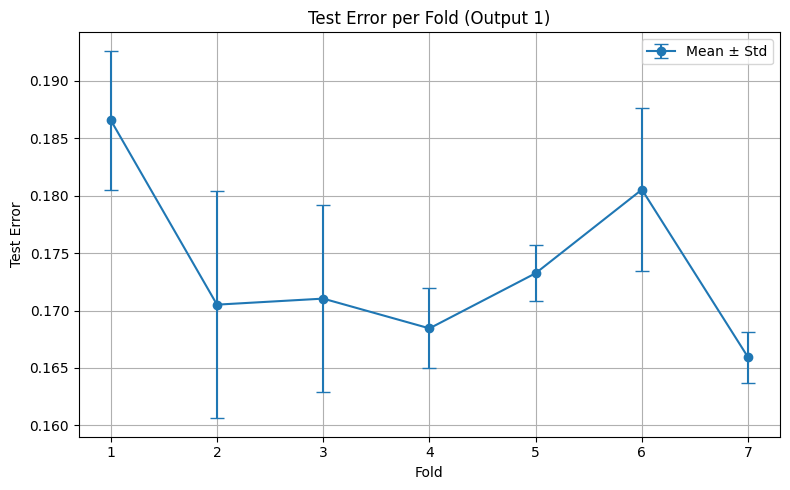


Summary Statistics (per training run):
          Run_1     Run_2     Run_3     Run_4     Run_5  Fold_Mean  Fold_Std
count  7.000000  7.000000  7.000000  7.000000  7.000000   7.000000  7.000000
mean   0.177641  0.173920  0.173722  0.169696  0.173799   0.173756  0.005621
std    0.010029  0.008564  0.010793  0.008026  0.010104   0.007279  0.002985
min    0.162639  0.159462  0.163236  0.159159  0.161449   0.165924  0.002201
25%    0.172113  0.169402  0.165823  0.164604  0.168194   0.169482  0.002968
50%    0.180298  0.174069  0.170893  0.168383  0.173436   0.171040  0.006046
75%    0.181010  0.181231  0.178783  0.174437  0.175954   0.176892  0.007634
max    0.194303  0.182645  0.192715  0.182245  0.193410   0.186577  0.009898

Per-fold Means and Std Devs:
   Fold_Mean  Fold_Std
0   0.186577  0.006046
1   0.170515  0.009898
2   0.171040  0.008170
3   0.168449  0.003476
4   0.173253  0.002459
5   0.180531  0.007098
6   0.165924  0.002201

Per-fold Summary (across runs):
         Fold_1    F

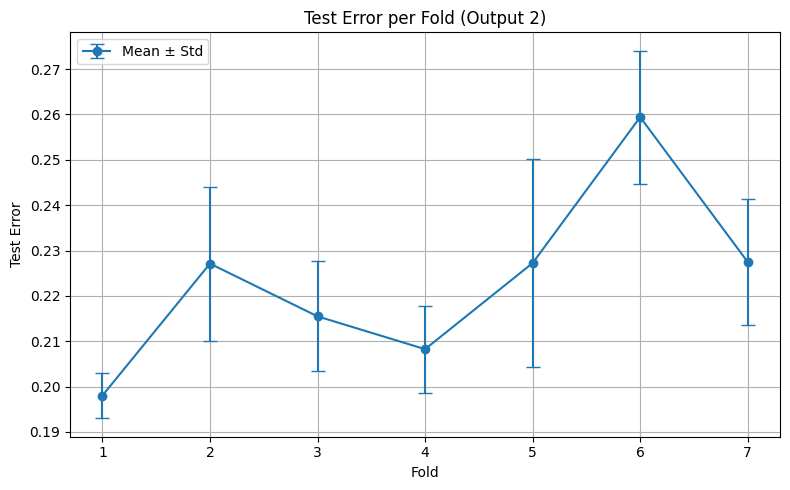


Summary Statistics (per training run):
          Run_1     Run_2     Run_3     Run_4     Run_5  Fold_Mean  Fold_Std
count  7.000000  7.000000  7.000000  7.000000  7.000000   7.000000  7.000000
mean   0.222886  0.238098  0.219526  0.222114  0.213824   0.223289  0.013604
std    0.024068  0.027940  0.026835  0.020188  0.016484   0.019485  0.005657
min    0.192438  0.202299  0.197259  0.194178  0.195685   0.198028  0.005024
25%    0.208280  0.217404  0.202288  0.207255  0.203245   0.211873  0.010861
50%    0.222378  0.231236  0.212952  0.222513  0.210493   0.227120  0.013911
75%    0.232268  0.262253  0.223542  0.238363  0.221558   0.227356  0.015800
max    0.264288  0.273833  0.274813  0.246875  0.240981   0.259419  0.022973

Per-fold Means and Std Devs:
   Fold_Mean  Fold_Std
0   0.198028  0.005024
1   0.227120  0.016956
2   0.215492  0.012114
3   0.208255  0.009607
4   0.227241  0.022973
5   0.259419  0.014643
6   0.227471  0.013911

Per-fold Summary (across runs):
         Fold_1    F

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assume sc_y_glob shape is (7, 5, 2) => (folds, runs, outputs)
n_outputs = sc_y_glob.shape[2]

for i in range(n_outputs):
    print(f"\n=== Summary for Output {i+1} ===")
    
    data_i = sc_y_glob[:, :, i]  # shape: (7, 5)
    
    fold_means = np.mean(data_i, axis=1)
    fold_stds = np.std(data_i, axis=1)

    overall_mean = np.mean(data_i)
    overall_std = np.std(data_i)

    # Print summary
    print("Per-Fold Means:", fold_means)
    print("Per-Fold Std Devs:", fold_stds)
    print(f"Overall Mean: {overall_mean:.4f}, Overall Std: {overall_std:.4f}")

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.errorbar(range(1, len(fold_means)+1), fold_means, yerr=fold_stds, fmt='o-', capsize=5, label='Mean ± Std')
    plt.title(f'Test Error per Fold (Output {i+1})')
    plt.xlabel('Fold')
    plt.ylabel('Test Error')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # DataFrame Summary
    df_results = pd.DataFrame(data_i, columns=[f"Run_{j+1}" for j in range(data_i.shape[1])])
    df_results["Fold_Mean"] = df_results.mean(axis=1)
    df_results["Fold_Std"] = df_results.std(axis=1)

    print("\nSummary Statistics (per training run):")
    print(df_results.describe())

    print("\nPer-fold Means and Std Devs:")
    print(df_results[["Fold_Mean", "Fold_Std"]])

    df_fold_view = df_results.drop(columns=["Fold_Mean", "Fold_Std"]).T
    df_fold_view.columns = [f"Fold_{k+1}" for k in range(df_fold_view.shape[1])]

    print("\nPer-fold Summary (across runs):")
    print(df_fold_view.describe())

C:\Users\vkeerth\AppData\Local\Temp\ipykernel_16320\3604107887.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend(loc='best')


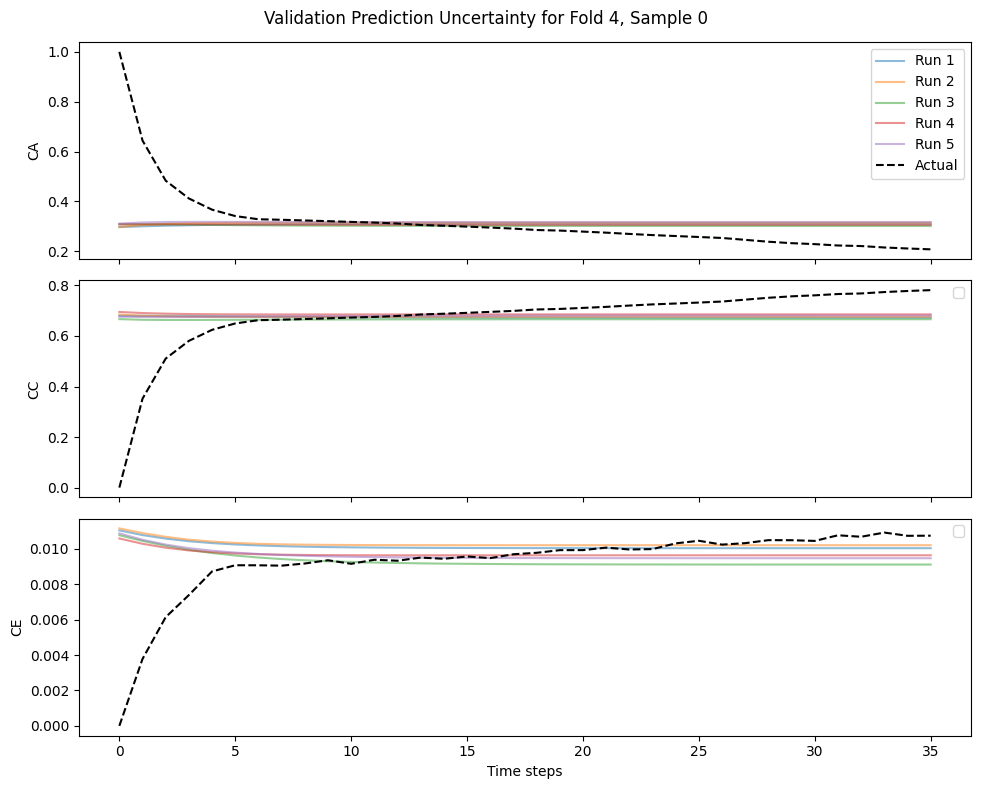

In [31]:
import matplotlib.pyplot as plt

fold_idx = 3  # choose fold
sample_idx = 0  # choose sample from validation set

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

time = np.arange(36)  # time steps

for i, label in enumerate(['CA', 'CC', 'CE']):
    for run in range(5):
        axs[i].plot(time, all_val_preds[fold_idx][run, sample_idx, :, i], alpha=0.5, label=f'Run {run+1}' if i==0 else None)

    axs[i].plot(time, val_targets[sample_idx, :, i], 'k--', label='Actual' if i==0 else None)
    axs[i].set_ylabel(label)
    axs[i].legend(loc='best')

axs[2].set_xlabel("Time steps")
plt.suptitle(f"Validation Prediction Uncertainty for Fold {fold_idx+1}, Sample {sample_idx}")
plt.tight_layout()
plt.show()


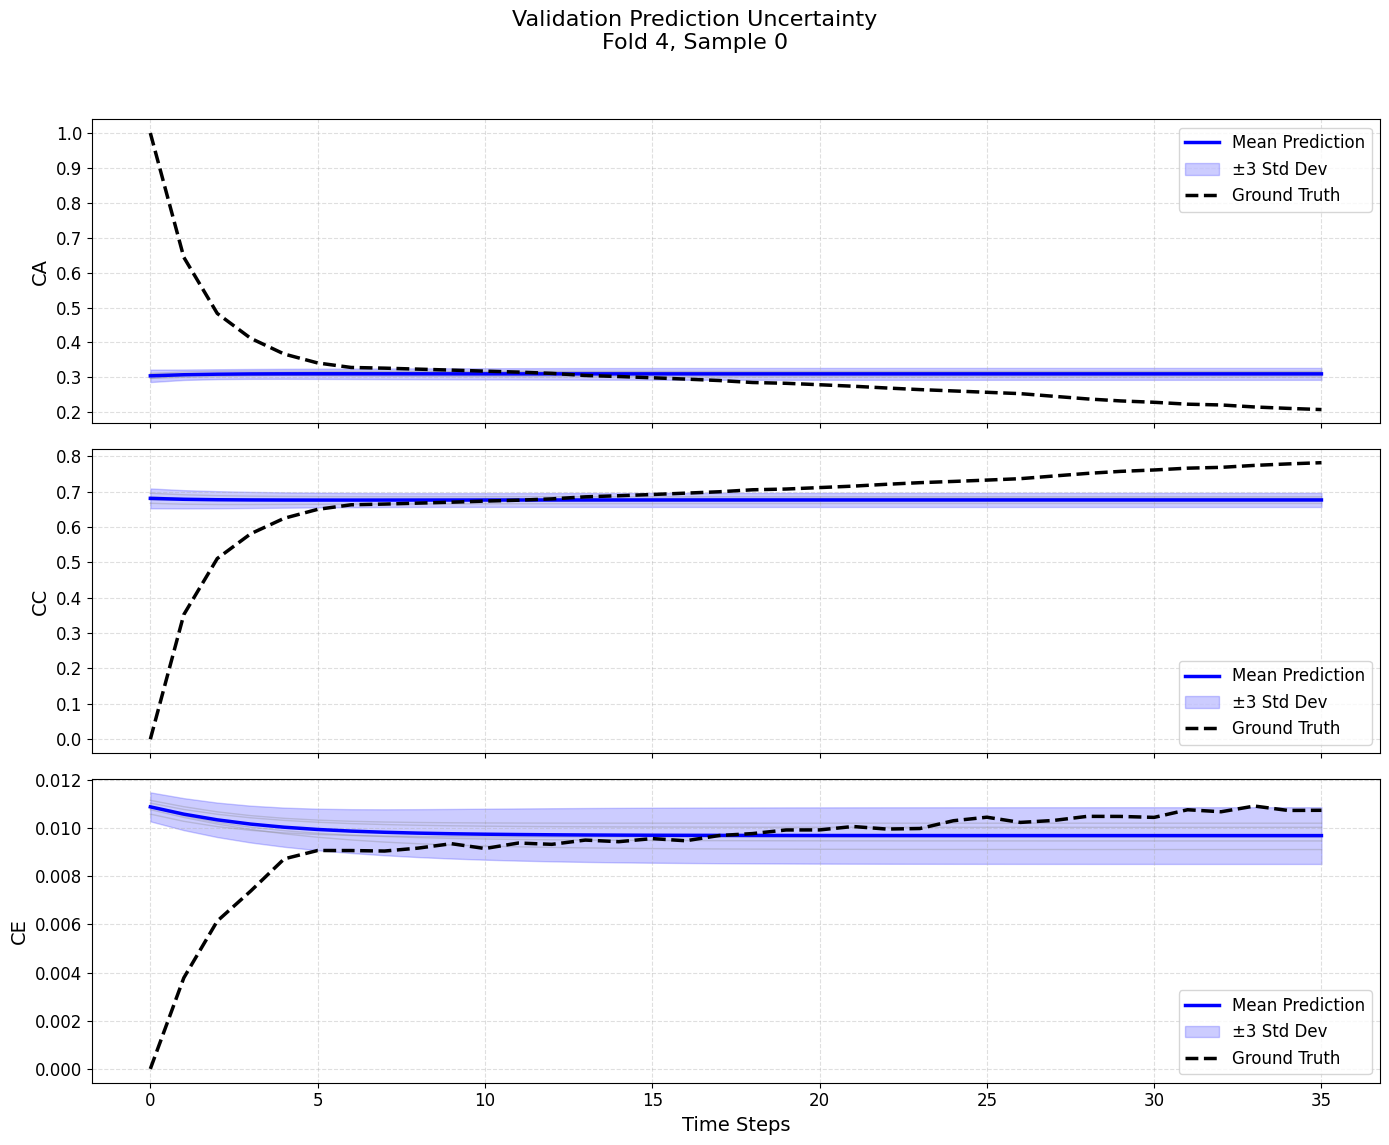

In [32]:
import matplotlib.pyplot as plt
import numpy as np

fold_idx = 3  # choose fold
sample_idx = 0  # choose sample from validation set
time = np.arange(36)  # time steps
labels = ['CA', 'CC', 'CE']

n_runs = len(all_val_preds[fold_idx])

# Bigger figure and fonts
fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

for i, label in enumerate(labels):
    runs = np.array([all_val_preds[fold_idx][run, sample_idx, :, i] for run in range(n_runs)])
    mean_pred = runs.mean(axis=0)
    std_pred = runs.std(axis=0)

    # Light individual runs
    for run in range(n_runs):
        axs[i].plot(time, runs[run], color='gray', alpha=0.3, linewidth=1)

    # Mean and uncertainty
    axs[i].plot(time, mean_pred, color='blue', linewidth=2.5, label='Mean Prediction')
    axs[i].fill_between(time, mean_pred - 3*std_pred, mean_pred + 3*std_pred, 
                        color='blue', alpha=0.2, label='±3 Std Dev')

    # Ground truth
    axs[i].plot(time, val_targets[sample_idx, :, i], 'k--', linewidth=2.5, label='Ground Truth')

    axs[i].set_ylabel(label, fontsize=14)
    axs[i].legend(loc='best', fontsize=12)
    axs[i].tick_params(labelsize=12)
    axs[i].grid(True, linestyle='--', alpha=0.4)

axs[-1].set_xlabel("Time Steps", fontsize=14)
plt.suptitle(f"Validation Prediction Uncertainty\nFold {fold_idx + 1}, Sample {sample_idx}", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()